# XGB Classifier

### Best score 0.89

### 0. Pakiety

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
import shap
shap.initjs()
from sklearn.model_selection import cross_val_score

### 1. Import danych

In [2]:
train = pd.read_csv('../Data/train_with_BMI.csv')
test = pd.read_csv('../Data/test_with_BMI.csv')
val = pd.read_csv('../Data/val_with_BMI.csv')

In [3]:
X_train = train.drop('NObeyesdad', axis=1)
y_train = train['NObeyesdad']
X_test = test.drop('NObeyesdad', axis=1)
y_test = test['NObeyesdad']
X_val = val.drop('NObeyesdad', axis=1)
y_val = val['NObeyesdad']

#### Objaśnienie labeli 

In [22]:
labels = ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II']

### 2. Strojenie parametrów

In [4]:
# param_grid = {
#     'max_depth': [ 4, 5, 7],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'subsample': [0.5, 0.75, 1.0],
#     'colsample_bytree': [0.5, 0.75, 1.0],
# }


# xgb = XGBClassifier()


# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


# grid_search.fit(X_train, y_train)


# print("Best parameters found: ", grid_search.best_params_)
# print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.75}
Best score found:  0.8903649746550352

### 3. Najlepszy model

In [5]:
final_model = XGBClassifier(random_state = 1, colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 7, n_estimators = 1000, 
                            subsample = 0.75, gamma = 0.5)
final_model.fit(X_train, y_train)
pred = final_model.predict(X_val)

print('Classification report:\n' , classification_report(y_val, pred))
print('Confusion matrix: \n', confusion_matrix(y_val, pred))

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       525
           1       0.86      0.89      0.87       624
           2       0.88      0.84      0.86       604
           3       0.95      0.97      0.96       714
           4       0.99      1.00      0.99       837
           5       0.76      0.76      0.76       532
           6       0.75      0.77      0.76       523

    accuracy                           0.89      4359
   macro avg       0.88      0.88      0.88      4359
weighted avg       0.89      0.89      0.89      4359

Confusion matrix: 
 [[481  38   0   0   0   4   2]
 [ 24 553   1   0   0  38   8]
 [  2   1 510  23   5  24  39]
 [  0   0  15 691   1   0   7]
 [  1   0   1   1 834   0   0]
 [  0  41  12   0   1 403  75]
 [  0  13  40   9   0  60 401]]


### 4. Confusion matrix

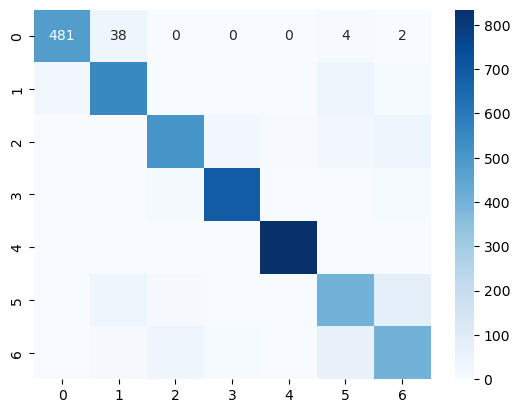

<Figure size 640x480 with 0 Axes>

In [7]:
#draw confusion matrix:
cm = confusion_matrix(y_val, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()
plt.savefig('../Images/XGBoost_train_confusion_matrix.png')


### 5. ROC Curve

In [23]:
def plot_roc_curve(y_true, y_prob, class_label, ax):
    """
    This function plots the ROC curve.
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_prob`: predicted probabilities
    'class_label': class label 
    `ax`: axis object to plot the ROC curve on
    
    Returns none.
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#1f77b4', linestyle='-', label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color = 'orange', linestyle = '--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ({})'.format(labels[class_label]))
    ax.legend(loc="lower right")

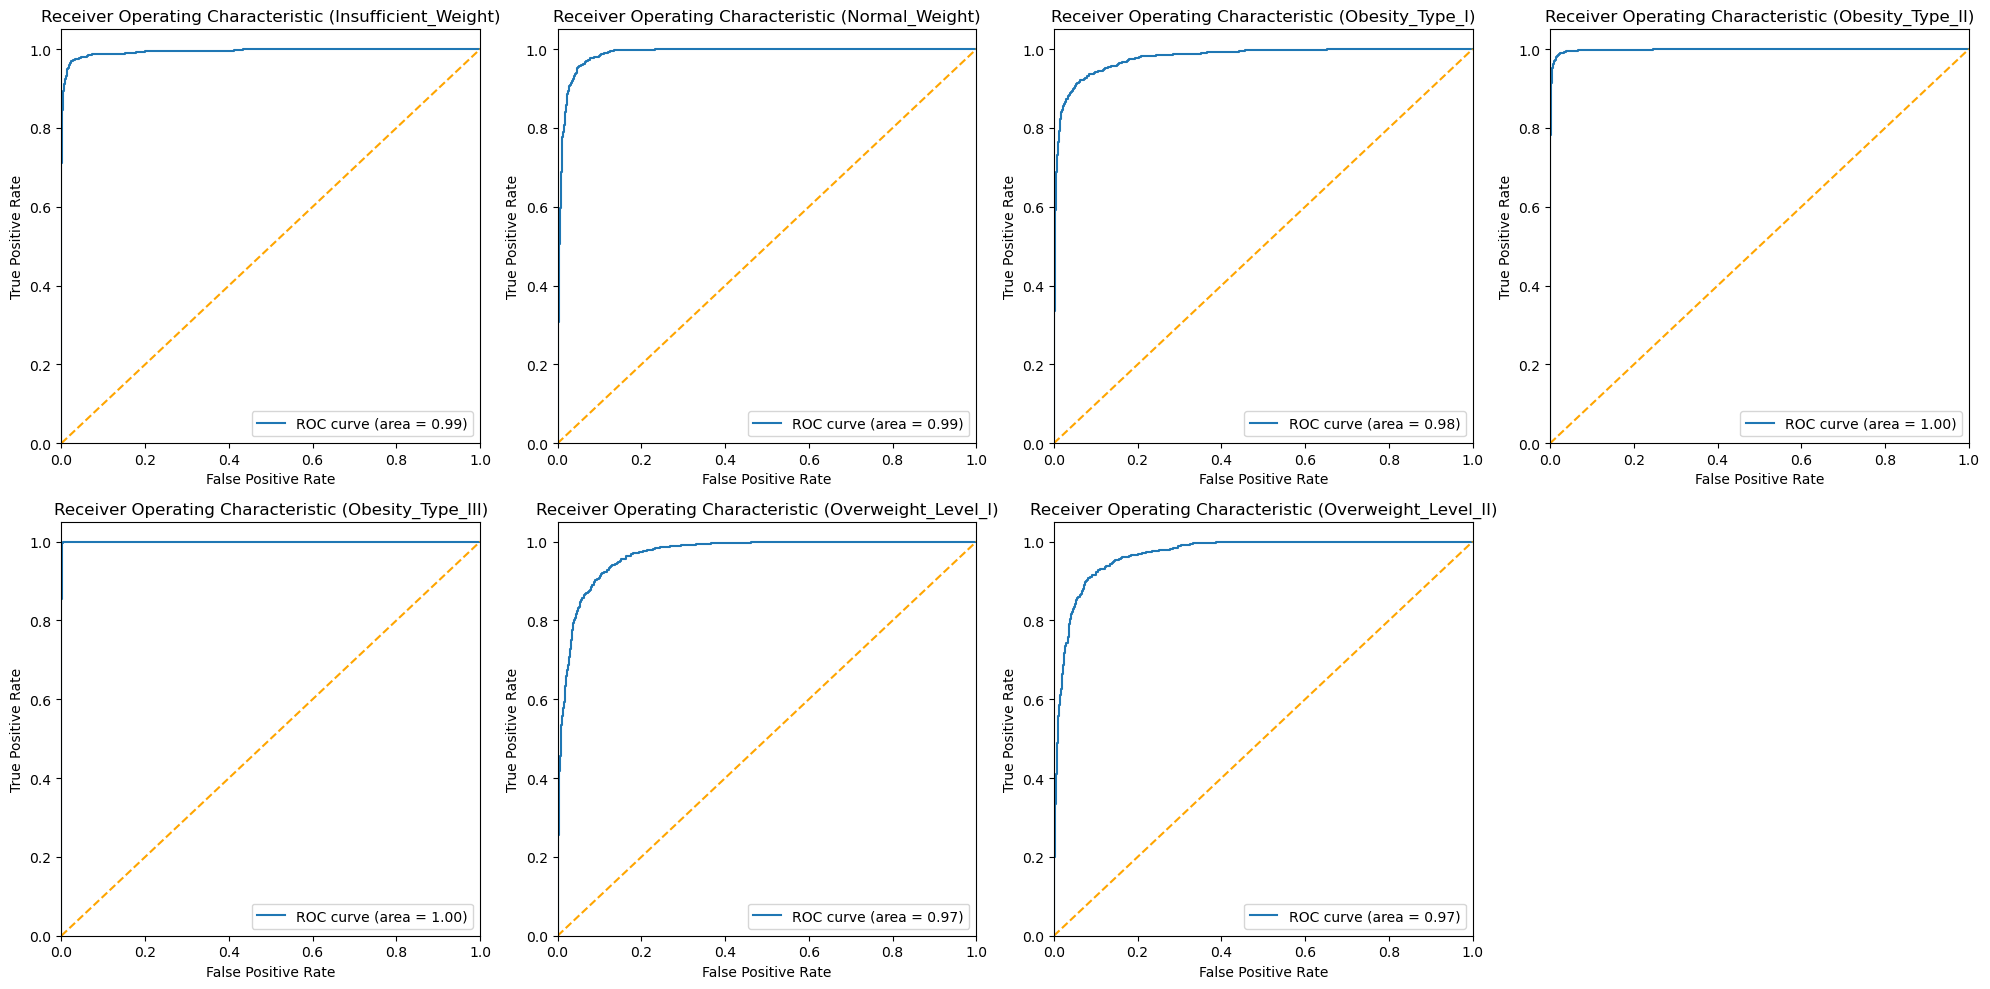

In [24]:
best_model = XGBClassifier(random_state = 1, colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 7, n_estimators = 1000, 
                            subsample = 0.75, gamma = 0.5)
best_model.fit(X_train, y_train)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()  # Flatten the array of axes objects

for i, ax in enumerate(axs):
    if i < len(best_model.classes_):
        y_true_binary = (y_val == best_model.classes_[i]).astype(int)
        y_prob = best_model.predict_proba(X_val)[:, i]
        plot_roc_curve(y_true_binary, y_prob, class_label=best_model.classes_[i], ax=ax)
    else:
        fig.delaxes(ax)  # Remove empty subplots if any

plt.tight_layout()
plt.show()

### 6. SHAP

In [19]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)

#### 6.1. Zestawienie ogólne

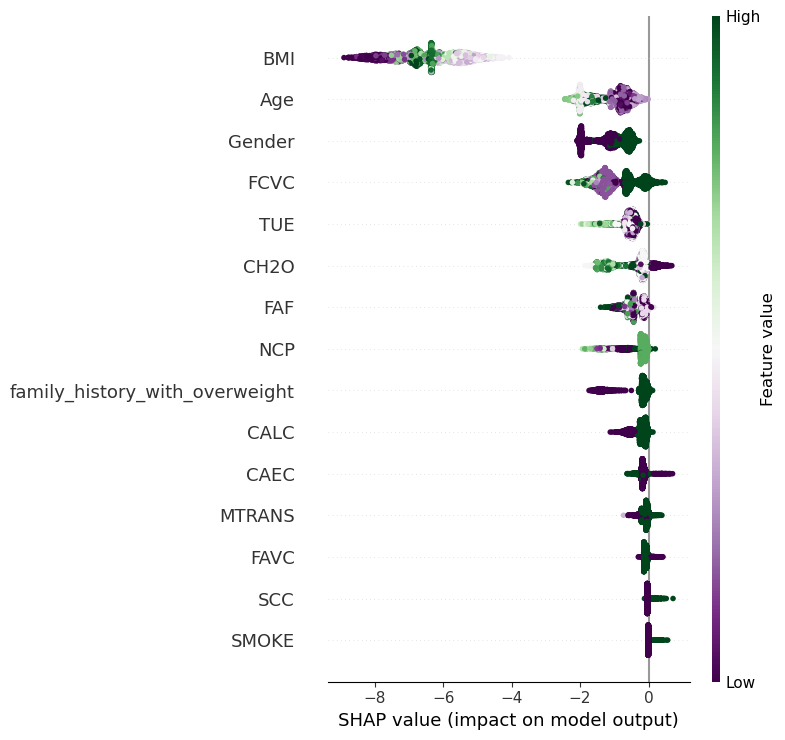

In [52]:
shap_values_sum = shap_values.sum(axis=2)

shap.summary_plot(shap_values_sum, X_val, cmap='PRGn')

#### 6.2. Pojedyncze klasy

In [30]:
print('Pierwsza obserwacja, klasa:' , labels[y_val.iloc[0]])

Pierwsza obserwacja, klasa: Obesity_Type_I


In [56]:
k = 0
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Insufficient_Weight


In [57]:
k = 1
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Normal_Weight


In [58]:
k = 2
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Obesity_Type_I


In [59]:
k = 3
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Obesity_Type_II


In [60]:
k = 4
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Obesity_Type_III


In [61]:
k = 5
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Overweight_Level_I


In [62]:
k = 6
print('Klasa: ' + labels[k])
shap.force_plot(explainer.expected_value[0], shap_values[0,:,k], X_val.iloc[0,:], feature_names=X_val.columns, plot_cmap = 'LpLb')

Klasa: Overweight_Level_II


### 7. Test na danych treningowych

In [45]:
pred = final_model.predict(X_train)

print('Classification report:\n' , classification_report(y_train, pred))

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1768
           1       0.90      0.92      0.91      2175
           2       0.93      0.92      0.92      2052
           3       0.98      0.98      0.98      2243
           4       1.00      1.00      1.00      2839
           5       0.88      0.83      0.85      1694
           6       0.87      0.88      0.87      1759

    accuracy                           0.93     14530
   macro avg       0.93      0.93      0.93     14530
weighted avg       0.93      0.93      0.93     14530



Accuracy na `X_train`: 0.93.

### 8. Kroswalidacja na danych treningowych

In [49]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=7)

print("Cross-validation scores: ", cv_scores)
print("Mean CV score: ", np.mean(cv_scores))    


Cross-validation scores:  [0.88198459 0.89595376 0.87331407 0.89643545 0.89017341 0.89349398
 0.89783133]
Mean CV score:  0.8898837961258742


Brak overfittingu.

### 9. Test na danych testowych

In [50]:
pred = final_model.predict(X_test)

print('Classification report:\n' , classification_report(y_test, pred))

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       230
           1       0.88      0.88      0.88       283
           2       0.89      0.86      0.88       254
           3       0.97      0.98      0.97       291
           4       1.00      1.00      1.00       370
           5       0.79      0.77      0.78       201
           6       0.79      0.80      0.80       240

    accuracy                           0.90      1869
   macro avg       0.89      0.89      0.89      1869
weighted avg       0.90      0.90      0.90      1869



Wynik na testowych: 0.90.

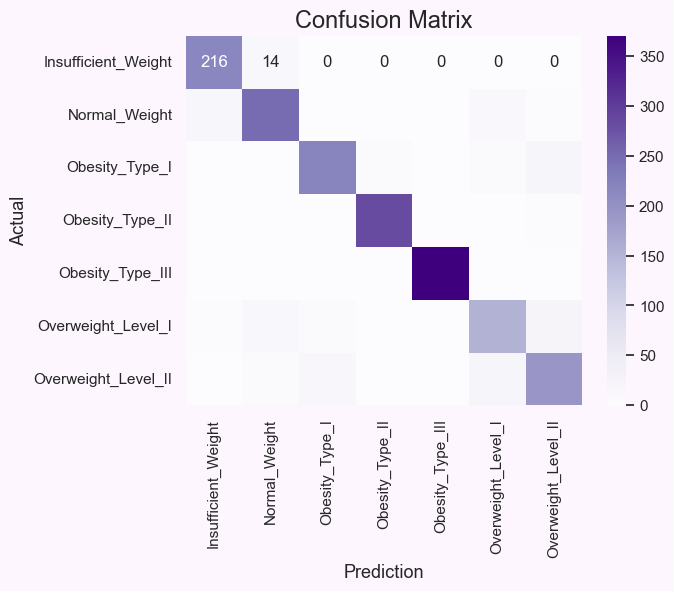

In [73]:
predicted = final_model.predict(X_test)

cm = confusion_matrix(y_test,predicted)
sns.heatmap(cm, 
            annot=True,
            fmt='.0f', 
            xticklabels=labels,
            yticklabels=labels, cmap='Purples')
sns.set_theme(rc={'axes.facecolor':'#fdf6ff', 'figure.facecolor' : '#fdf6ff'})
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()